## *Fine tune* CNN model
With fine tunning here we refer to the process of training the same CNN architecture:
* Using the weights of the *transfered* task (here imagenet classification) as starting points in sgd.
* We let some layers to be *fixed* (i.e. not updating the parameters of them).

In [2]:
import dogs_vs_cats as dvc
all_files = dvc.image_files()

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5105)


data file train.zip has already been downloaded
Data has already been extracted


In [3]:
# load model without top layer
n_images_train=500
n_images_test=500
input_image_shape = (3,224,224)
train_features, train_labels,train_files, \
test_features, test_labels, test_files = dvc.training_test_datasets(all_files,
                                                                    n_images_train,n_images_test,
                                                                    input_image_shape)

Loading train set
loading image (1/500)
loading image (101/500)
loading image (201/500)
loading image (301/500)
loading image (401/500)
Loading test set
loading image (1/500)
loading image (101/500)
loading image (201/500)
loading image (301/500)
loading image (401/500)


In [4]:
from keras.applications.imagenet_utils import preprocess_input

# load_img from keras.preprocessing loads the images in [0,255] scale
train_features*=255
test_features*=255
train_features = preprocess_input(train_features)
test_features = preprocess_input(test_features)

In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

base_model = VGG16(weights='imagenet')

model_conv_vgg = Model(input=base_model.input, output=base_model.get_layer('flatten').output)

train_features_convs = model_conv_vgg.predict(train_features,verbose=1)

500/500 [==============================] - 13s     


In [6]:
test_features_convs = model_conv_vgg.predict(test_features,verbose=1)

500/500 [==============================] - 13s     


In [7]:
model_conv_vgg.output_shape

(None, 25088)

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dense

model_fc_vgg = Sequential([
    Dense(4096, activation='relu', name='fc1',input_dim=train_features_convs.shape[1]),
    Dense(4096, activation='relu', name='fc2'),
    Dense(1, activation='sigmoid', name='predictions_new')
])

# Copy to weights to have them as an initialization
model_fc_vgg.get_layer('fc1').set_weights([w for w in base_model.get_layer("fc1").get_weights()])
model_fc_vgg.get_layer('fc2').set_weights([w for w in base_model.get_layer("fc2").get_weights()])
model_fc_vgg.get_layer('fc1').trainable = False
model_fc_vgg.get_layer('fc2').trainable = True

In [9]:
model_fc_vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
fc1 (Dense)                      (None, 4096)          102764544   dense_input_1[0][0]              
____________________________________________________________________________________________________
fc2 (Dense)                      (None, 4096)          16781312    fc1[0][0]                        
____________________________________________________________________________________________________
predictions_new (Dense)          (None, 1)             4097        fc2[0][0]                        
Total params: 119,549,953
Trainable params: 16,785,409
Non-trainable params: 102,764,544
____________________________________________________________________________________________________


In [10]:
model_fc_vgg.compile(optimizer="adam", 
                     loss='binary_crossentropy',metrics=['accuracy'])

nb_epoch=80
print("Model compiled, start training")
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                        verbose=0, mode='auto')
history = model_fc_vgg.fit(train_features_convs,
                           train_labels,validation_split=.1,
                           batch_size=32, nb_epoch=nb_epoch,verbose=2,callbacks=[early_stopping_callback])

Model compiled, start training
Train on 450 samples, validate on 50 samples
Epoch 1/80
0s - loss: 1.0616 - acc: 0.8800 - val_loss: 0.9565 - val_acc: 0.9400
Epoch 2/80
0s - loss: 0.9135 - acc: 0.9400 - val_loss: 1.1493 - val_acc: 0.9000
Epoch 3/80
0s - loss: 1.2644 - acc: 0.9178 - val_loss: 1.9131 - val_acc: 0.8800
Epoch 4/80
0s - loss: 0.9869 - acc: 0.9356 - val_loss: 1.1566e-07 - val_acc: 1.0000
Epoch 5/80
0s - loss: 0.7185 - acc: 0.9533 - val_loss: 0.6377 - val_acc: 0.9600
Epoch 6/80
0s - loss: 0.6537 - acc: 0.9578 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 7/80
0s - loss: 0.3084 - acc: 0.9778 - val_loss: 1.5942 - val_acc: 0.9000
Epoch 8/80
0s - loss: 1.0654 - acc: 0.9267 - val_loss: 0.3188 - val_acc: 0.9800
Epoch 9/80
0s - loss: 1.0525 - acc: 0.9311 - val_loss: 0.3189 - val_acc: 0.9800
Epoch 10/80
0s - loss: 0.4398 - acc: 0.9689 - val_loss: 1.2754 - val_acc: 0.9200


In [13]:
results = model_fc_vgg.evaluate(test_features_convs,test_labels)
print(" ".join(["%s: %.4f"%(metric_name,valor) for metric_name,valor in zip(model_fc_vgg.metrics_names,results)]))

500/500 [==============================] - 0s     
loss: 0.7641 acc: 0.9520


500/500 [==============================] - 0s     


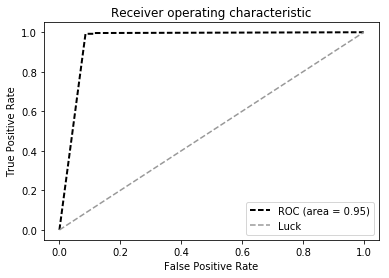

In [15]:
preds = model_fc_vgg.predict(test_features_convs,verbose=1)
%matplotlib inline
dvc.plotROC(test_labels,preds)